# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## traffic_fines_1

### data preprocessing

#### importing libraries and terminology

In [1]:
#import libraries

In [2]:
import pandas as pd
import numpy as np
import time
import os
import random
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
import xgboost as xgb

In [3]:
#user specified packages from Teinemaa
from DatasetManager import DatasetManager

In [4]:
#tree packages
import graphviz
from sklearn import tree

#LSTM
import numpy as np
import pandas as pd
from pandas import Series
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import logging
plt.style.use('fivethirtyeight')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

from collections import OrderedDict
from collections import defaultdict

import tensorflow.keras
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Reshape, Activation, Multiply, TimeDistributed, concatenate, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import OrdinalEncoder

C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\ten

Terminology

In [5]:
params_dir = './params_dir'
results_dir = './results' 
cls_encoding = 'agg'

gap = 1
n_iter = 1

bucket_encoding = "agg"

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

In [6]:
#terminology

In [7]:
dataset_ref = 'traffic_fines_1'

In [8]:
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

In [9]:
# print dataset name

In [10]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: traffic_fines_1


In [11]:
# read the data

In [12]:
dataset_manager = DatasetManager(dataset_name)

In [13]:
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [14]:
#terminology

In [15]:
params_dir = './params_dir'
results_dir = './results' 
DT_dir = './DT_dir'
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22

In [16]:
# determine min and max (truncated) prefix lengths

In [17]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

In [18]:
max_prefix_length

10

#### data preprocessing

In [19]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [20]:
#prefix generation of train and test data

In [21]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [22]:
dt_train_prefixes_original = dt_train_prefixes.copy()
dt_test_prefixes_original = dt_test_prefixes.copy()

In [23]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [24]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [25]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

### LSTM

#### poging 5

In [26]:
#functions

def prepare_inputs(X_train, X_test, data):    
    oe = OrdinalEncoder()
    oe.fit(data)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def numeric_padding(sequences, maxlen=None, value=0):
    num_samples = len(sequences)
    sample_shape = np.asarray(sequences[0]).shape[1:]
    x = np.full((num_samples, maxlen) + sample_shape, value)
    for idx, s in enumerate(sequences):
        trunc = s[:maxlen]
        x[idx, :maxlen] = trunc[0]
        
def normalist(lst):
    s = sum(lst)
    norm = [float(i)/s for i in lst]
    return norm

    return x   

In [27]:
#TRANSFORMATION

#categorical columns integercoded

dt_train_prefixes.dtypes

cat_columns = ['Activity']

dt_train_prefixes[cat_columns],dt_test_prefixes[cat_columns]= prepare_inputs(dt_train_prefixes[cat_columns], dt_test_prefixes[cat_columns], data[cat_columns])



dt_train_prefixes[cat_columns] = dt_train_prefixes[cat_columns]+1

dt_test_prefixes[cat_columns] = dt_test_prefixes[cat_columns]+1

#make embeddings

dt_train_prefixes.dtypes

cat_columns.append('Case ID')
cat_columns.append('label')

cat_columns

ans_train = [pd.DataFrame(y) for x, y in dt_train_prefixes[cat_columns].groupby('Case ID', as_index=False)]
ans_test = [pd.DataFrame(y) for x, y in dt_test_prefixes[cat_columns].groupby('Case ID', as_index=False)]

train_labels = []
for i in range (0,len(ans_train)):
    temp_label = ans_train[i]['label'].iloc[0]
    train_labels.append(temp_label)

test_labels = []
for i in range (0,len(ans_test)):
    temp_label = ans_test[i]['label'].iloc[0]
    test_labels.append(temp_label)

train_y = [1 if i!='regular' else 0 for i in train_labels]
test_y = [1 if i!='regular' else 0 for i in test_labels]

cat_columns.remove('label')
cat_columns.remove('Case ID')

cat_columns

maxlen = max_prefix_length

In [28]:
#cutoff: max amount of events in a prefix
cutoff = maxlen
no_activities= len(data.groupby(['Activity']))+1

In [29]:
#padding of the different categorical columns
#train paddings
paddings_train = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_train)):
        temp = []
        temp = list(ans_train[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_train.append(padded)

#test paddings
paddings_test = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_test)):
        temp = []
        temp = list(ans_test[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_test.append(padded)

In [30]:
##### numerical columns
#NUMERICAL COLUMNS
numerical_columns = ['timesincelastevent',
'Case ID']

dt_train_prefixes2 = dt_train_prefixes[numerical_columns]
dt_test_prefixes2 = dt_test_prefixes[numerical_columns]

ans_train2 = [pd.DataFrame(y) for x,y in dt_train_prefixes2.groupby('Case ID', as_index=False)]
ans_test2 = [pd.DataFrame(y) for x,y in dt_test_prefixes2.groupby('Case ID', as_index=False)]

In [31]:
pad_train = []
pad_test  = []
num_columns = ['timesincelastevent']
for i in num_columns:
    padding = []
    for k in range(0,len(ans_train2)):
        temp_train = []
        temp_train = list(ans_train2[k][i])
        padding.append(temp_train)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_train.append(padded)
for i in num_columns:
    padding = []
    for k in range(0,len(ans_test2)):
        temp_test = []
        temp_test = list(ans_test2[k][i])
        padding.append(temp_test)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_test.append(padded)

#### LSTM model

In [32]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional,TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Softmax, Lambda, Multiply, Dropout
from tensorflow.keras import backend
from tensorflow.keras.layers import GlobalAveragePooling1D
import tensorflow.keras.utils as ku

In [33]:
def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    for i, _ in enumerate(subsec_set):
        alias[subsec_set[i]] = i + 1
    return alias


ac_index = create_index(dt_train_prefixes_original, 'Activity')
ac_index['Start'] = 0
ac_index['End'] = len(ac_index)
index_ac = {v: k for k, v in ac_index.items()}

ac_weights = ku.to_categorical(sorted(index_ac.keys()), len(ac_index))

In [34]:
dropout_input = 0.01
dropout_context=0.30
lstm_size_alpha=64
lstm_size_beta=64
print("Training prefix and variable attention model")

l2reg=0.001
allow_negative=False
incl_time = True 
incl_res = True
#Code Input
#categorical embeddings
input_layer_a = Input(shape=(cutoff,), name='activity_input')

time_input_layer = Input(shape=(cutoff,1), name='time_input')

########################################
#inputs_list = [ac_input]
   
#Calculate embedding for each code and sum them to a visit level
embedding_activity = Embedding(ac_weights.shape[0],
                            ac_weights.shape[1],
                            weights=[ac_weights],
                            input_length=no_activities,
                           name='ac_embedding')(input_layer_a)
dim =ac_weights.shape[1]


full_embs = embedding_activity

#Apply dropout on inputs
full_embs = Dropout(dropout_input)(full_embs)
time_embs = concatenate([full_embs, time_input_layer], name='allInp')

dim += 1

alpha = Bidirectional(LSTM(lstm_size_alpha, return_sequences=True),
                                    name='alpha')
beta = Bidirectional(LSTM(lstm_size_beta, return_sequences=True),
                                   name='beta')
alpha_dense = Dense(1, kernel_regularizer=l2(l2reg))
beta_dense = Dense(dim, activation='tanh', kernel_regularizer=l2(l2reg))

#Compute alpha, visit attention
alpha_out = alpha(time_embs)
alpha_out = TimeDistributed(alpha_dense, name='alpha_dense_0')(alpha_out)
alpha_out = Softmax(axis=1, name='alpha_softmax')(alpha_out)
#Compute beta, codes attention
beta_out = beta(time_embs)
beta_out = TimeDistributed(beta_dense, name='beta_dense_0')(beta_out)
#Compute context vector based on attentions and embeddings
c_t = Multiply()([alpha_out, beta_out, time_embs])
c_t = Lambda(lambda x: backend.sum(x, axis=1))(c_t)
        #Reshape to 3d vector for consistency between Many to Many and Many to One implementations
        #contexts = L.Lambda(reshape)(c_t)

#Make a prediction
contexts = Dropout(dropout_context)(c_t)
 
output_layer = Dense(1, activation='sigmoid', name='final_output')(contexts)

Training prefix and variable attention model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
model = Model(inputs=[input_layer_a, time_input_layer], outputs=output_layer)

In [36]:
opt = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999,
                   epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'final_output':'binary_crossentropy'}, optimizer= opt)
    
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
activity_input (InputLayer)     [(None, 10)]         0                                            
__________________________________________________________________________________________________
ac_embedding (Embedding)        (None, 10, 12)       144         activity_input[0][0]             
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 12)       0           ac_embedding[0][0]               
__________________________________________________________________________________________________
time_input (InputLayer)         [(None, 10, 1)]      0                                            


In [37]:
output_file_path = os.path.join('./', 'models/model_rd_'+'_{epoch:02d}-{val_loss:.2f}.h5')

In [38]:
padded_time = np.reshape(pad_train[0], (len(pad_train[0]), cutoff, 1))
padded_time_test=  np.reshape(pad_test[0], (len(pad_test[0]), cutoff, 1))

model_checkpoint = ModelCheckpoint(output_file_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=2,
                                   verbose=0,
                                   mode='auto',
                                   min_delta=0.0001,
                                   cooldown=0,
                                   min_lr=0)
model_inputs = [paddings_train[0]]
model_inputs.append(padded_time)

In [39]:
start = time.time()
model.fit(model_inputs,
              train_y,
              callbacks=[early_stopping, lr_reducer],
              validation_split = 0.1,
              verbose=1,
              epochs=10)
model_inputs_test = [paddings_test[0]]
model_inputs_test.append(padded_time_test)
predictions = model.predict(model_inputs_test)
auc = roc_auc_score(test_y,predictions)
total_time = time.time() - start
print(total_time)
print(auc)

Train on 325884 samples, validate on 36210 samples
Epoch 1/10
325884/325884 [==============================] - 204s 626us/sample - loss: 0.6061 - val_loss: 0.6288
Epoch 2/10
325884/325884 [==============================] - 205s 630us/sample - loss: 0.5969 - val_loss: 0.6290
Epoch 3/10
325884/325884 [==============================] - 208s 638us/sample - loss: 0.5877 - val_loss: 0.6082
Epoch 4/10
325884/325884 [==============================] - 210s 644us/sample - loss: 0.5700 - val_loss: 0.5940
Epoch 5/10
325884/325884 [==============================] - 211s 646us/sample - loss: 0.5657 - val_loss: 0.5946
Epoch 6/10
325884/325884 [==============================] - 212s 650us/sample - loss: 0.5648 - val_loss: 0.5964
Epoch 7/10
325884/325884 [==============================] - 212s 652us/sample - loss: 0.5528 - val_loss: 0.5849
Epoch 8/10
325884/325884 [==============================] - 210s 645us/sample - loss: 0.5532 - val_loss: 0.5869
Epoch 9/10
325884/325884 [===========================

In [40]:
"""model_name = 'BPIC2017_PC10'
model_json = model.to_json()
with open('./models/'+model_name+".json", "w") as json_file:
            json_file.write(model_json)
            # serialize weights to HDF5
            model.save_weights('./models/'+model_name+".h5")
            print("Saved model to disk")
            print('Name: '+model_name)
"""

'model_name = \'BPIC2017_PC10\'\nmodel_json = model.to_json()\nwith open(\'./models/\'+model_name+".json", "w") as json_file:\n            json_file.write(model_json)\n            # serialize weights to HDF5\n            model.save_weights(\'./models/\'+model_name+".h5")\n            print("Saved model to disk")\n            print(\'Name: \'+model_name)\n'

In [40]:
preds_all = list(predictions)
method_name = "attention"
cls_method = "LSTM"

In [41]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [42]:
len(nr_events_all)

88530

In [43]:
len(predictions)

88530

In [44]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", total_time/10))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(auc))

In [ ]:
print('Opening model')
json_file = open('./models/'+model_name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model2 = model_from_json(loaded_model_json)
# load weights into new model
print('Opening weights')
model2.load_weights('./models/'+model_name+".h5")
print("Loaded model from disk")

In [46]:
#   Next event selection method and numbers of repetitions
#variants = [{'imp': 'Arg Max', 'rep': 1}]#,
               # {'imp': 'Random Choice', 'rep': 1}]
#   Generation of predictions
has_time=False
    #model = load_model(os.path.join(output_route, parameters['model_file']))
model = model
layer_names = [layer.name for layer in model.layers]
print(layer_names)
l_emb_weights=None
ac_emb_weights = model.get_layer(name='ac_embedding').get_weights()[0]

#s_emb_weights = model.get_layer(name='s_embedding').get_weights()[0]
    
#at_emb_weights = model.get_layer(name='at_embedding').get_weights()[0]  
    
#acc_emb_weights = model.get_layer(name='acc_embedding').get_weights()[0]  
    
#li_emb_weights = model.get_layer(name='li_embedding').get_weights()[0]  

has_time=True

ac_output_weights, ac_bias = model.get_layer(name='final_output').get_weights()
print(ac_output_weights)
model_with_attention = Model(model.inputs, model.outputs +\
                                              [model.get_layer(name='alpha_softmax').output,\
                                               model.get_layer(name='beta_dense_0').output])

['activity_input', 'ac_embedding', 'dropout', 'time_input', 'allInp', 'alpha', 'alpha_dense_0', 'beta', 'alpha_softmax', 'beta_dense_0', 'multiply', 'lambda', 'dropout_1', 'final_output']
[[ 0.8989455]
 [ 1.3632356]
 [-1.4996749]
 [ 1.7230282]
 [ 1.6923013]
 [-1.655468 ]
 [ 1.5437582]
 [-1.5942062]
 [ 1.8839384]
 [ 1.6874458]
 [-1.6068759]
 [ 1.5423888]
 [ 5.0626965]]


In [47]:
maxlen

10

In [48]:
temporal_vectors = []
variable_vectors=[]
predictions = []
for i in range(0,len(paddings_test[0])):
    x_ac_ngram = paddings_test[0][i].reshape((1,cutoff))
    #x_s_ngram = paddings_test[1][i].reshape((1,cutoff))
    #x_at_ngram = paddings_test[2][i].reshape((1,cutoff))
    #x_acc_ngram = paddings_test[3][i].reshape((1,cutoff))
    #x_li_ngram = paddings_test[4][i].reshape((1,cutoff))
    #x_in_ngram  = pad_creditscore_test[i].reshape(1, 40, 1)
    x_t_ngram   = padded_time_test[i].reshape(1, 10, 1)
    betas=None      
    proba, alphas, betas = model_with_attention.predict([x_ac_ngram,x_t_ngram])
    #print(proba, alphas, betas)
    proba = np.squeeze(proba)
    alphas = np.squeeze(alphas)
    temporal_att_vec = alphas
    assert (np.sum(temporal_att_vec) - 1.0) < 1e-5
    #print(temporal_att_vec)
    temporal_vectors.append(temporal_att_vec)

    if betas is not None:
        #get the beta value
        betas = np.squeeze(betas)
        idx = np.argmax(alphas)
        #print(idx)
        beta_val = betas[idx]
        # get the activity and role for that idx
        act_ip = int(x_ac_ngram[0][idx])
        ac_emb = ac_emb_weights[act_ip]
        dim=ac_emb.shape[0]
        
        if(betas.shape[1]==dim+1):
            time_v = np.squeeze(x_t_ngram)[idx]  # time and role as masked together
            emb = np.concatenate((ac_emb,time_v), axis=None)
          
        #print('beta_val',beta_val.shape)
        beta_scaled = np.multiply(beta_val,emb)
        variable_attn = alphas[idx] * beta_scaled
        #sum_grad = np.sum(ac_output_weights, axis=1)
        #variable_attn=np.multiply(sum_grad.flatten(), variable_attn)
        #if pos!=test_y[i]:
            #temporal_vectors[i] = np.zeros(40, dtype='float32')
            #variable_attn = np.zeros(52, dtype='float32')
            #variable_vectors.append(variable_attn)
        predictions.append(proba)
        variable_vectors.append(variable_attn)

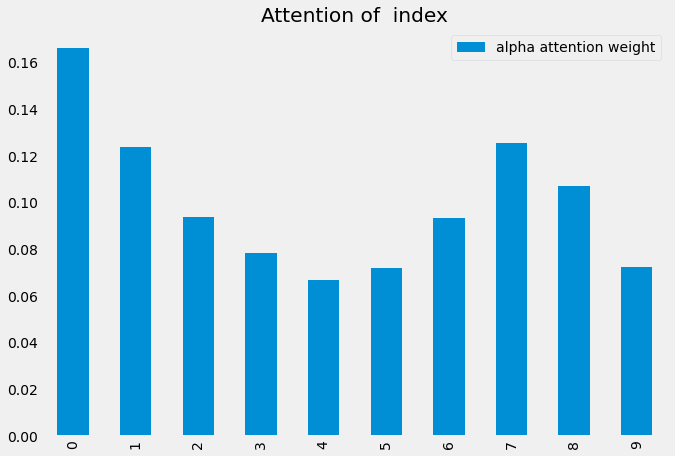

In [49]:
temp_final = np.mean(np.array(temporal_vectors), axis=0)
pd.DataFrame(temp_final, columns=['alpha attention weight']).plot(kind='bar',
                                                                        title='Attention of '
                                                                              ' index', figsize=(10,7))
# Hide grid lines
plt.grid(False)
plt.show()

['Start', 'Add penalty', 'Appeal to Judge', 'Create Fine', 'Insert Date Appeal to Prefecture', 'Insert Fine Notification', 'Notify Result Appeal to Offender', 'Payment', 'Receive Result Appeal from Prefecture', 'Send Appeal to Prefecture', 'Send Fine', 'End']
    attributes                       attribute_values
0    -0.016653                                  Start
1    -0.017281                            Add penalty
2     0.006606                        Appeal to Judge
3    -0.004981                            Create Fine
4    -0.003785       Insert Date Appeal to Prefecture
5     0.008304               Insert Fine Notification
6    -0.003774       Notify Result Appeal to Offender
7     0.003098                                Payment
8    -0.007095  Receive Result Appeal from Prefecture
9    -0.005575              Send Appeal to Prefecture
10    0.006248                              Send Fine
11   -0.004853                                    End
12   -0.000095                        

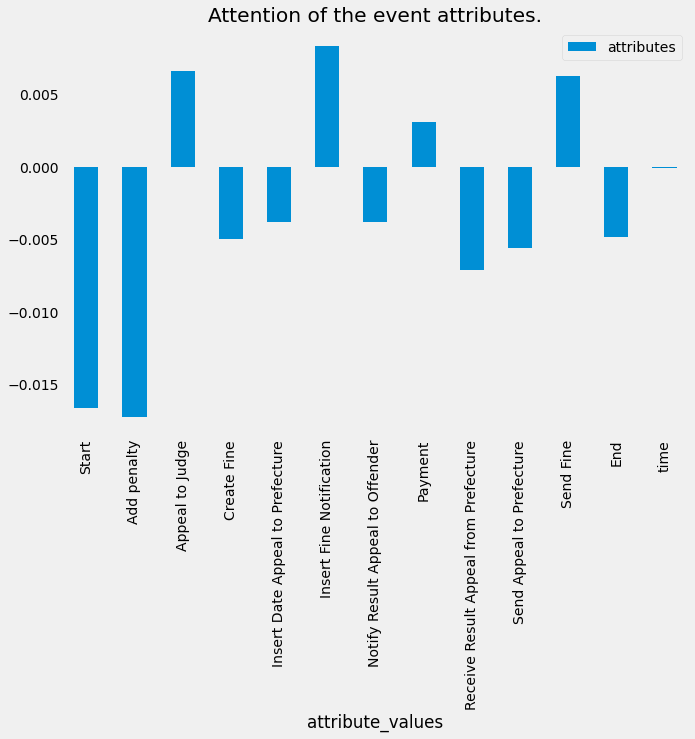

In [50]:
if(len(variable_vectors)>0):
    var_final = np.mean(np.array(variable_vectors), axis=0)
    ac_labels = [index_ac[key] for key in sorted(index_ac.keys())]
    
    print(ac_labels)
    

 #   if s_emb_weights is not None:
  #      ac_labels.extend(s_labels)
  #  if at_emb_weights is not None:
  #      ac_labels.extend(at_labels)  
  #  if acc_emb_weights is not None:
  #      ac_labels.extend(acc_labels)
   # if li_emb_weights is not None:
   #     ac_labels.extend(li_labels)
    #ac_labels.append('CreditScore')
    ac_labels.append('time')
        
    df_var=pd.DataFrame({'attributes':var_final, 'attribute_values':ac_labels})
    print(df_var)
    df_var.plot.bar(y='attributes', x='attribute_values',
                                title='Attention of the event attributes.', figsize=(10,7))
                                                                               
    #plot_history( plt, file_name + 'variable_attn', path )
      

    # Hide grid lines
    plt.grid(False)
    plt.show()

#### Parsimony

In [56]:
len(df_var['attributes'])

len(df_var[round(df_var['attributes'],4)==0])

len(df_var[df_var['attributes']==0])

0

#### Functional Complexity

In [57]:
def functional_complexity(n_instances):
    NF=0
    NF2 = 0
    #categorical_columns
    list_of_random_instances = list(np.random.permutation(np.arange(0,n_instances))[:n_instances])
    for j in range(0,len(paddings_test)-1):
        for i in list_of_random_instances:
            new_paddings_test = paddings_test.copy()
            #new prediction after permutation 
            new_paddings_test[j][i] = random.uniform(0,1)
            new_model_inputs_test = [[np.array(new_paddings_test[0][i])]]
            #new_model_inputs_test.append([np.array(new_paddings_test[1][i])])
            #new_model_inputs_test.append([np.array(new_paddings_test[2][i])])
            #new_model_inputs_test.append([np.array(new_paddings_test[3][i])])
            #new_model_inputs_test.append([np.array(new_paddings_test[5][i])])
         
            new_model_inputs_test.append([np.array(padded_time_test[0])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            #model_inputs_test.append([np.array(paddings_test[1][i])])
            #model_inputs_test.append([np.array(paddings_test[2][i])])
            #model_inputs_test.append([np.array(paddings_test[3][i])])
            #model_inputs_test.append([np.array(paddings_test[5][i])])

            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            if pred1 != pred2:
               
                NF = NF+1
    #numerical
    list_of_sets=[]
    set_of_values = set()
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list        
    for j in range(0,len(num_columns)):
        set_of_values = set(dt_test_prefixes[num_columns[j]])
        for i in list_of_random_instances:
            new_pad_test = pad_test.copy()
            new_pad_test[j][i] = random.choice(list(set_of_values))
           
            new_padded_time_test=  np.reshape(new_pad_test[0], (len(new_pad_test[0]), cutoff, 1))

            #new prediction after permutation
           
            new_model_inputs_test = [[np.array(paddings_test[0][i])]]
            #new_model_inputs_test.append([np.array(paddings_test[1][i])])
            #new_model_inputs_test.append([np.array(paddings_test[2][i])])
            #new_model_inputs_test.append([np.array(paddings_test[3][i])])
            #new_model_inputs_test.append([np.array(paddings_test[5][i])])

            new_model_inputs_test.append([np.array(new_padded_time_test[i])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            #model_inputs_test.append([np.array(paddings_test[1][i])])
            #model_inputs_test.append([np.array(paddings_test[2][i])])
            #model_inputs_test.append([np.array(paddings_test[3][i])])
            #model_inputs_test.append([np.array(paddings_test[5][i])])

            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            
            if pred1 != pred2:
                NF2 = NF2+1           
                
    
    return NF, NF2

In [58]:
functional_complexity(500)

(0, 0)

#### Monotonicity

##### perturbation importance

In [57]:
len(model_inputs_test[0])

88530

In [58]:
numbers = [no_activities,1]

sample_length = len(model_inputs_test[0])
effects_saved = []
def data_sample(model_inputs):
    sample_data = []
    for i in range(0, len(model_inputs)):
        sample_data.append(model_inputs[i][0:sample_length])
    return sample_data
def var_importance(model, model_inputs):
    x = data_sample(model_inputs)
    orig_out = model.predict(x)
    for i in range(0,len(cat_columns)):  # iterate over the 5 cat features
        print(i)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        new_x[i] = np.array(perturbations_list)
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/10).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        effects_saved.append(effect)
    for k in range(i+1,len(model_inputs)):  # iterate over the 10 num features
        print(k)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        perturbation_array = np.array(perturbations_list)
        perturbations_reshaped = perturbation_array.reshape(sample_length, cutoff, 1)
        new_x[k] = perturbations_reshaped
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/10).mean() ** 0.5
        print(f'Variable {(k+1)}, perturbation effect: {effect:.4f}')    
        effects_saved.append(effect)

var_importance(model, model_inputs_test)

0
Variable 1, perturbation effect: 0.1603
1
Variable 2, perturbation effect: 0.1773


In [59]:
len([index_ac[key] for key in sorted(index_ac.keys())])

12

In [60]:
abs(df_var['attributes'].iloc[0:12]).sum(skipna = True)

0.088253215

In [61]:
abs(df_var['attributes'].iloc[12:13]).sum(skipna = True)

9.4535266e-05

In [62]:
len(df_var)

13

In [63]:
df_var

,attributes,attribute_values
0,-0.016653,Start
1,-0.017281,Add penalty
2,0.006606,Appeal to Judge
3,-0.004981,Create Fine
4,-0.003785,Insert Date Appeal to Prefecture
5,0.008304,Insert Fine Notification
6,-0.003774,Notify Result Appeal to Offender
7,0.003098,Payment
8,-0.007095,Receive Result Appeal from Prefecture
9,-0.005575,Send Appeal to Prefecture


In [64]:
attention_values = [0.22694795,0.007822689]

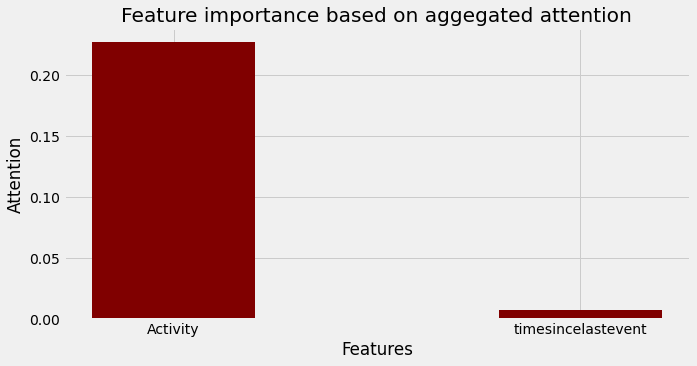

In [65]:
courses = ['Activity','timesincelastevent']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, attention_values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on aggegated attention")
plt.show()

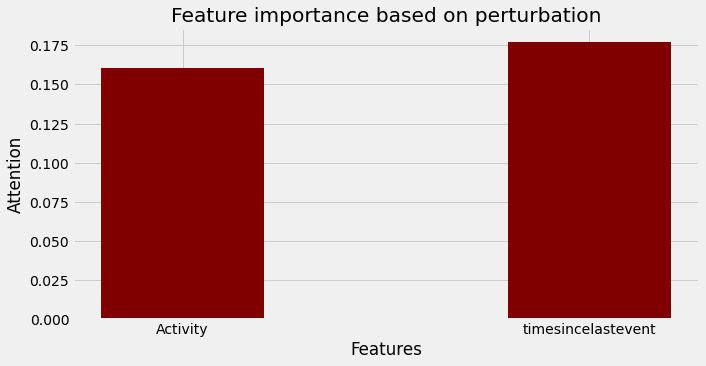

In [66]:
values = effects_saved
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on perturbation")
plt.show()

In [67]:
from scipy.stats import kendalltau

coef, p = kendalltau(effects_saved, attention_values)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

from scipy.stats import spearmanr
# seed random number generator

Kendall correlation coefficient: -1.000
Samples are uncorrelated (fail to reject H0) p=1.000


In [68]:
# prepare data

coef, p = spearmanr(effects_saved, attention_values)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -1.000
Samples are correlated (reject H0) p=nan
